# Dimension, Information, Dynamics, and Time Series

We measure the extraction of information and geometry from nonlinear systems over time in many ways. 

TODO: 
1) Datasets: time series datasets (logistic map, chaotic attractors), image datasets (MNIST), manifold (swiss roll with extra dimensions)
2) Embedding algos: takens (TS), PCA, MLP-AE, CNN-AE, Koopman-AE, etc.

Data Compression: 
1) measure I(X,X_comp), reconstruciton loss (MSE/NMSE), loss in predictive power (true y vs. f(x_compressed)), etc.

Time series forecasting: 
1) finite vs infinite dimensional methods (takens-MLP vs Koopman AE)
2) see above in data compression



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter
%run random_shannon_fcns.ipynb

## Helpers

In [2]:
# helper functions: 
def plot_delay(data, tau): 
    x = data[:-tau]  
    y = data[tau:]  
    
    plt.scatter(x, y, s=1, alpha=0.7)  
    plt.xlabel(f'x(t)')
    plt.ylabel(f'x(t+{tau})')
    plt.title(f'Delay Embedding (τ={tau})')
    plt.show()

# def L2_matrix(X):
#     X_norm = np.sum(X**2, axis=1, keepdims=True)
    
#     return np.sqrt(X_norm + X_norm.T - 2 * X @ X.T)

def L2_matrix(X):
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        X = X[:, None]                      
    Xn = np.sum(X*X, axis=1)
    D2 = Xn[:, None] + Xn[None, :] - 2.0 * (X @ X.T)
    np.maximum(D2, 0, out=D2) 
    
    return np.sqrt(D2)
    
# good vlues for r: 0.1 * max(d(x_i, x_j)), 0.2 * stdev(X) where x_i is a delay vector 
# X in the def below is a 1d time series
def recurrence_mat(X, r, dim=2, delay=1):
    T = delay_embed(X, dim, delay)
    D = L2_matrix(T)

    R = (D < r).astype(int)

    return R

def plot_recurrence(X, r, dim, delay, title="Recurrence Plot"):
    R = recurrence_mat(X, r, dim=dim, delay=delay)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(R, cmap='binary', origin='lower')
    plt.title(title)
    plt.xlabel('Time i')
    plt.ylabel('Time j')
    plt.colorbar(label='Recurrence')
    plt.show()
    

def calculate_pca_loss_to_dim(X, pca, dim_min, dim_max): 
    pca_recon_loss_list = []
    for i in range(dim_min, dim_max+1): 
        loss, _, _ = pca_recon_loss(X, pca, i)
        pca_recon_loss_list.append(loss)

    return pca_recon_loss_list

def calculate_pca_feature_loss_to_dim(X, pca, dim_min, dim_max): 
    N = dim_max - dim_min + 1
    k = X.shape[1]
    feature_loss_mat = np.zeros((N, k))
    for i in range(N): 
        _, feature_loss, _ = pca_recon_loss(X, pca, i+dim_min)
        feature_loss_mat[i] = feature_loss

    return feature_loss_mat

def plot_pca_recon_loss(X, pca, dim_min, dim_max): 
    res = calculate_pca_loss_to_dim(X, pca, dim_min, dim_max)

    plt.title("PCA Reconstruction Loss (MSE) vs. Dimension")
    plt.xlabel("Dimension")
    plt.ylabel("MSE")
    plt.plot(np.arange(dim_min, dim_max+1), res, '.')
    plt.show()

### Loss and Error Functions

In [3]:
def pe(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return (y_pred - y) / y

def ape(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return np.abs(y_pred - y) / np.abs(y)

def squared_error(y, y_pred): 
    y, y_pred = np.asarray(y), np.asarray(y_pred)
    return (y_pred - y)**2

def MAPE(y, y_pred): 
    return np.mean(ape(y, y_pred))

def MSE(y, y_pred): 
    return np.mean(squared_error(y, y_pred))

class PredError:
    """
    A class to encapsulate prediction error calculations and plotting.
    """
    def __init__(self, y_true, y_pred):
        """
        Initializes the class and calculates all relevant error metrics.
        """
        self.y_true = np.asarray(y_true)
        self.y_pred = np.asarray(y_pred)

        # This private method is called to compute all errors at once
        self._calculate_all_errors()

    def _calculate_all_errors(self):
        """Calculates pointwise and aggregate errors."""
        # Pointwise errors (for plotting)
        self.pe = pe(self.y_true, self.y_pred)
        self.ape = ape(self.y_true, self.y_pred)
        self.squared_error = squared_error(self.y_true, self.y_pred)
        
        # Aggregate errors (for reporting)
        self.mape = MAPE(self.y_true, self.y_pred)
        self.mse = MSE(self.y_true, self.y_pred)

    def plot(self, error_type='squared_error'):
        """
        Plots a specific type of pointwise error.
        
        Args:
            error_type (str): The error to plot. Can be 'pe', 'ape', 
                              or 'squared_error'.
        """
        error_data = {
            'pe': self.pe,
            'ape': self.ape,
            'squared': self.squared_error
        }
        
        titles = {
            'pe': 'Pointwise Percentage Error (PE)',
            'ape': 'Pointwise Absolute Percentage Error (APE)',
            'squared': 'Pointwise Squared Error'
        }

        if error_type not in error_data:
            valid_types = ", ".join(error_data.keys())
            raise ValueError(f"Invalid error_type '{error_type}'. Please choose from: {valid_types}")

        plt.figure(figsize=(12, 6))
        plt.plot(error_data[error_type])
        plt.title(f"{titles[error_type]} on Test Set")
        plt.xlabel("Time Step")
        plt.ylabel(error_type.upper())
        plt.grid(True)
        plt.show()

## Time Series Data

In [4]:
def logistic_map(r, x_0, max_iter=1000):
    """Generates a time series using the logistic map equation."""
    traj = [x_0]
    for i in range(1, max_iter):
        x = r * traj[i-1] * (1 - traj[i-1])
        traj.append(x)
    return np.array(traj, dtype=np.float32)

def weierstrass(x, a, b, max_n):
    """Generates a time series using the Weierstrass function."""
    res = np.zeros_like(x, dtype=np.float32)
    for i in range(max_n):
        res += a**i * np.cos(b**i * np.pi * x)
    return res

def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [5]:
def mackey_glass_discrete(N=10000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    size = N + tau + 1
    x = np.empty(size, dtype=float)
    x[:tau+1] = float(x0) 

    for t in range(tau, size - 1):
        x_tau = x[t - tau]
        x[t + 1] = (1.0 - gamma) * x[t] + beta * x_tau / (1.0 + x_tau**n)

    return x[tau+1:]

## Time Series Analysis

### Logistic Map

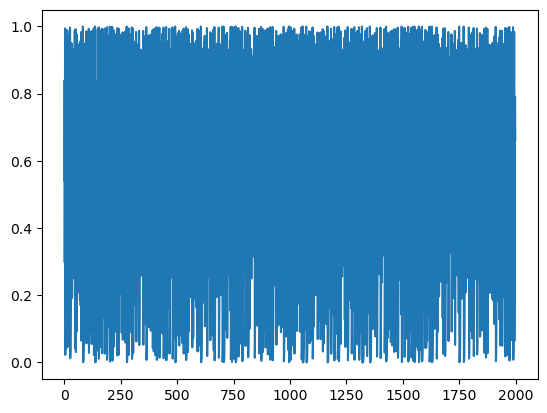

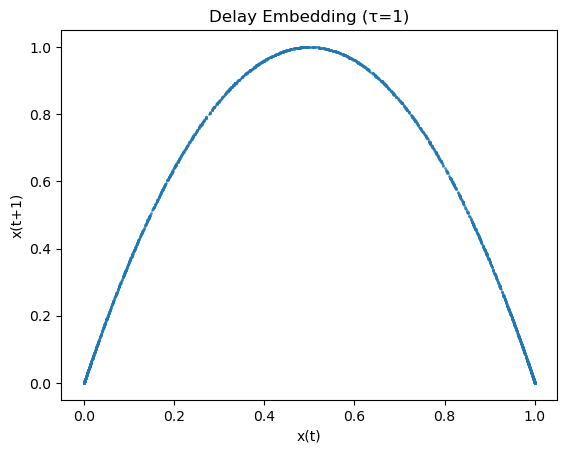

0.34909543


In [6]:
mu, sig = 0, 0.02
N = 2000
lgm = logistic_map(4.0, 0.3, N)

plt.plot(lgm)
plt.show()

plot_delay(lgm, 1)

print(np.std(lgm))

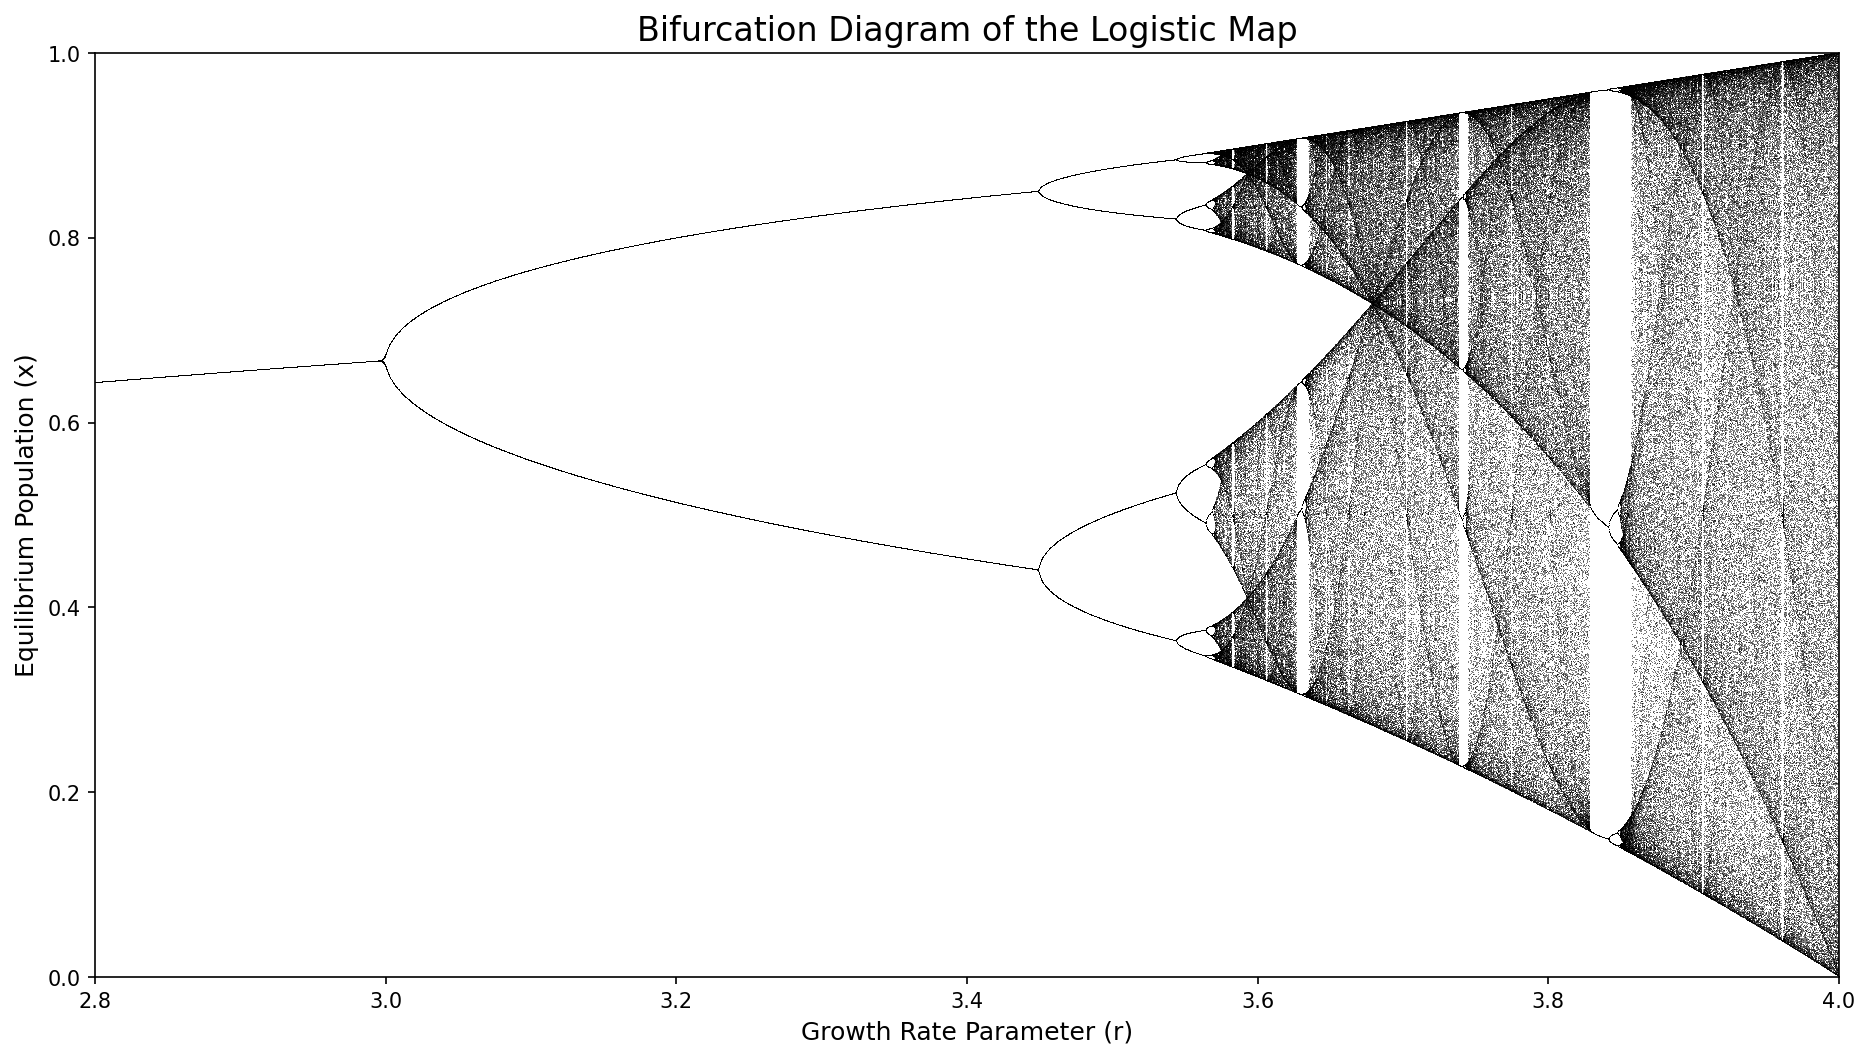

In [7]:
plot_bifur_logistic(np.linspace(2.8, 4.0, 5000))

In [8]:
# range_r = (3.4, 4.0)
# num_r = 100
# r_values = np.linspace(range_r[0], range_r[1], num_r)

# entropy_list = []
# for val in r_values: 
#     data = logistic_map(val, 0.2, 200)
#     radius = 0.1 * np.std(data)
#     entropy_list.append(approx_entropy(data, 1, 2, radius))

# plt.plot(r_values, entropy_list)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


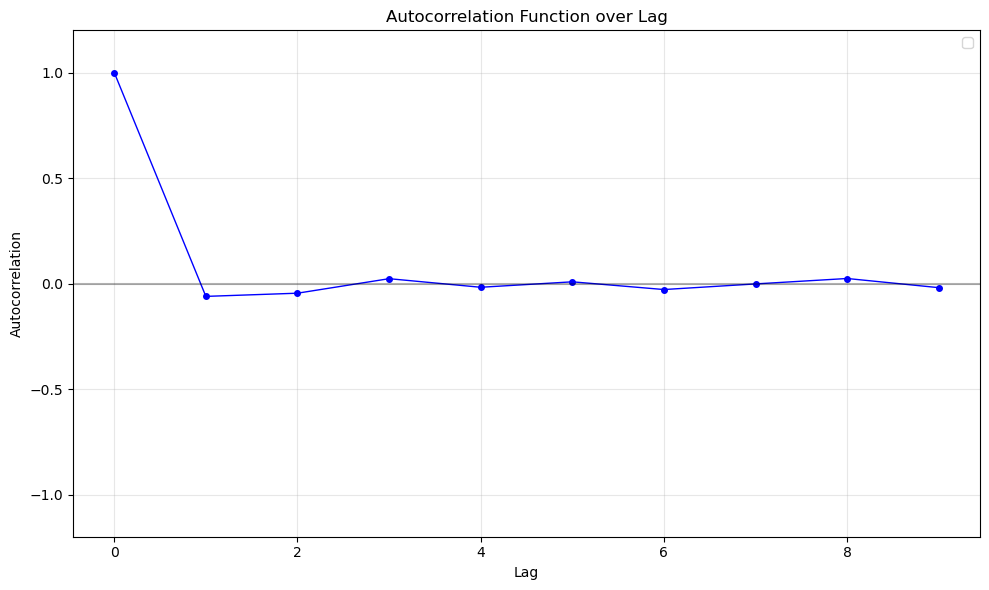

[1.0,
 -0.060946253078538404,
 -0.045826187069656646,
 0.0229407519703313,
 -0.017718719426153176,
 0.008090424668584721,
 -0.028505724584660323,
 -0.0018370428460934261,
 0.023828432279581417,
 -0.019547766501821745]

In [9]:
plot_acf(lgm, 10)

In [10]:
dim, delay = 20, 1
lgm_embedded = delay_embed(lgm, dim, delay)
lgm_delaypca, pca_lgm = delayPCA(lgm, dim, delay, dim)

lgm_pca_recon_loss = calculate_pca_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)
lgm_pca_feature_loss = calculate_pca_feature_loss_to_dim(lgm_embedded, pca_lgm, 2, dim)

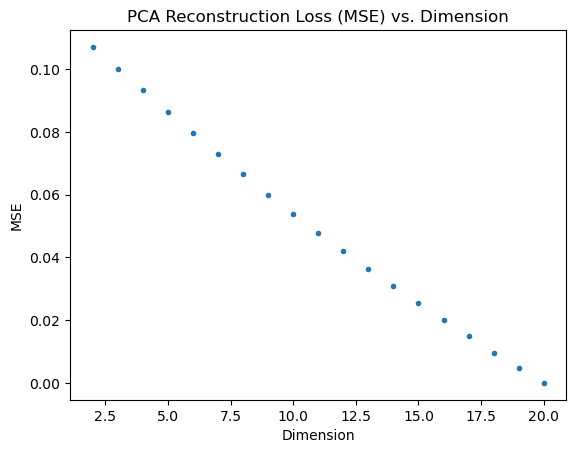

In [11]:
plot_pca_recon_loss(lgm_embedded, pca_lgm, 2, dim)

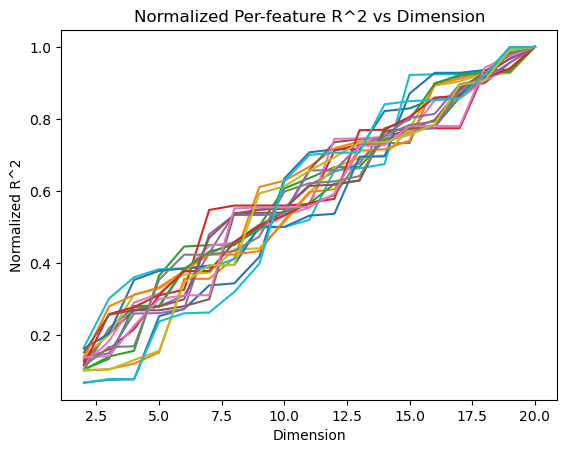

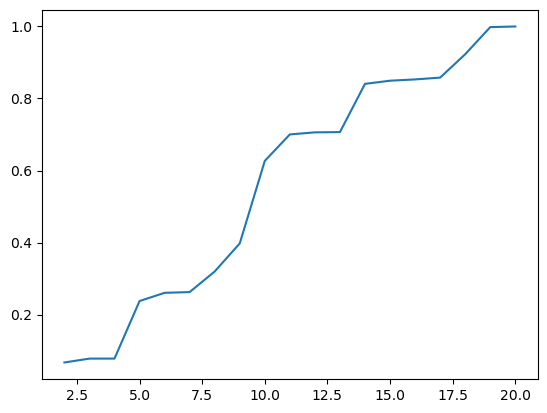

In [12]:
k_feat = 19

plt.title("Normalized Per-feature R^2 vs Dimension")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, :20])
plt.xlabel('Dimension')
plt.ylabel('Normalized R^2')
plt.show()

plt.title("")
plt.plot(np.arange(2, dim+1), lgm_pca_feature_loss[:, k_feat])
plt.show()

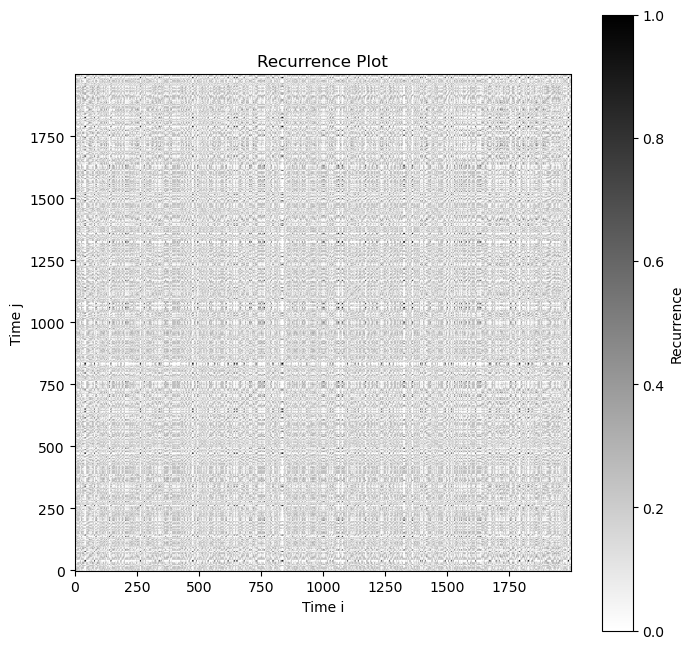

In [13]:
plot_recurrence(lgm, 0.5*np.std(lgm), 2, 1)

### Weierstrass Function 

In [14]:
ts_length = 10000
x_val = np.linspace(-2*np.pi, 4*np.pi, ts_length)
a = 0.87
b = 3.0
max_n = 100

wire = weierstrass(x_val, a, b, max_n) + np.random.normal(0, 0.1, ts_length)

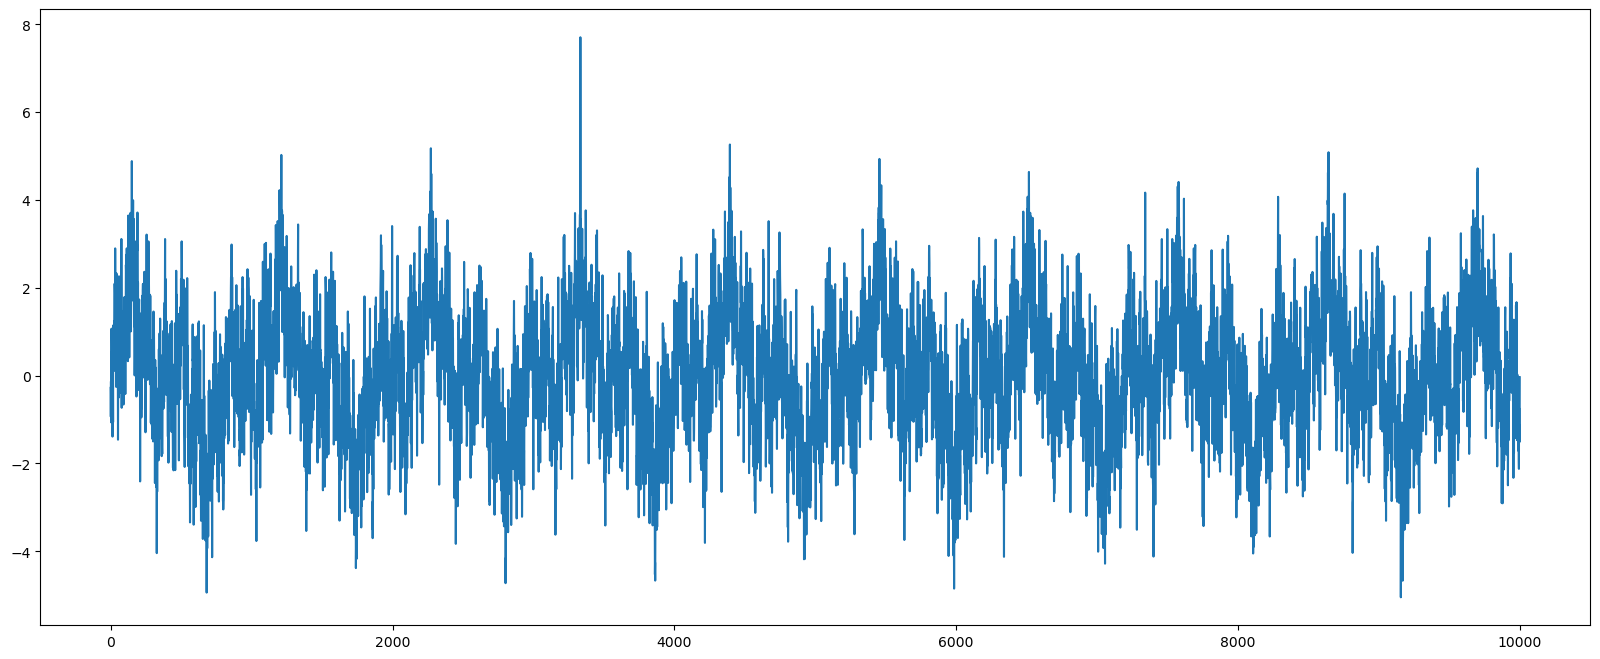

In [15]:
plt.figure(figsize=(20,8))
plt.plot(wire)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


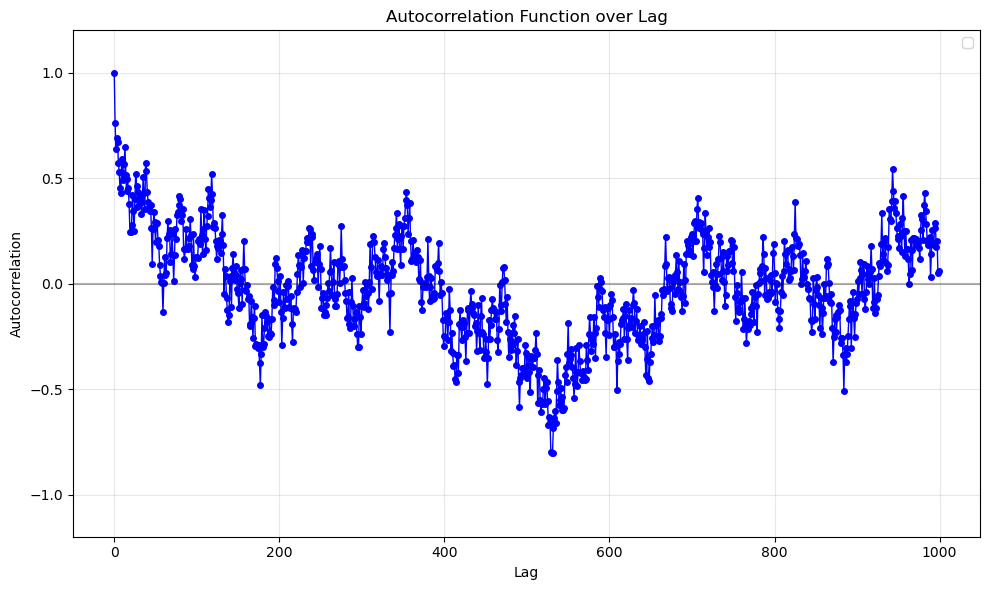

In [16]:
acf_wire = plot_acf(wire, 1000)

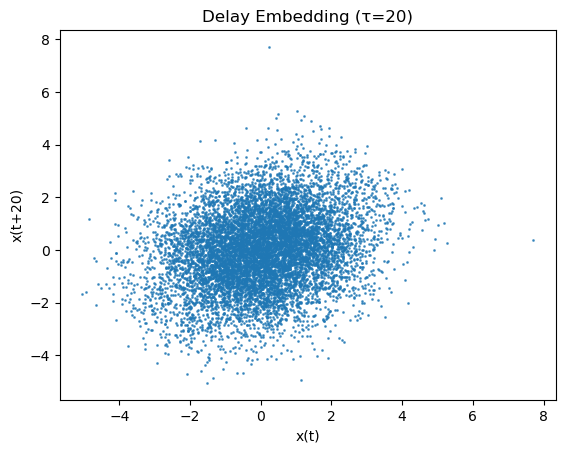

In [17]:
plot_delay(wire, 20)

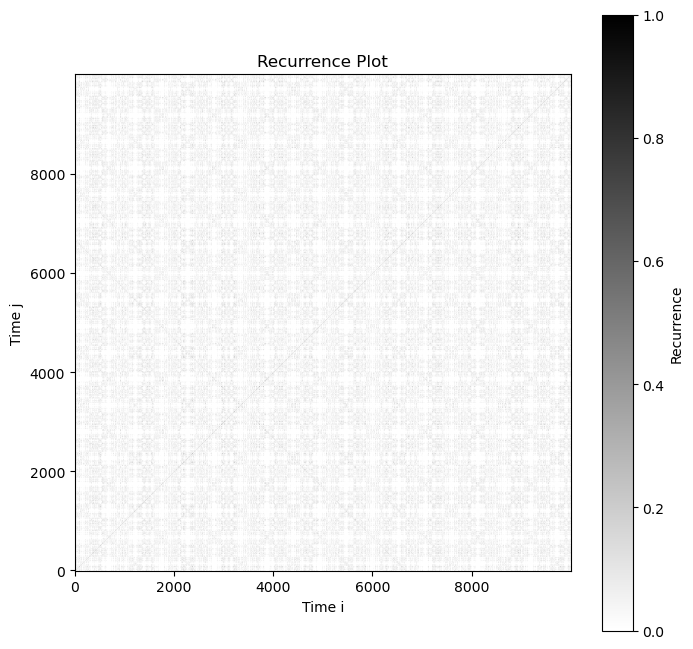

In [18]:
plot_recurrence(wire, 0.3*np.std(wire), 2, 1)

### Mackey-Glass

In [19]:
mgd = mackey_glass_discrete(N=5000, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2)

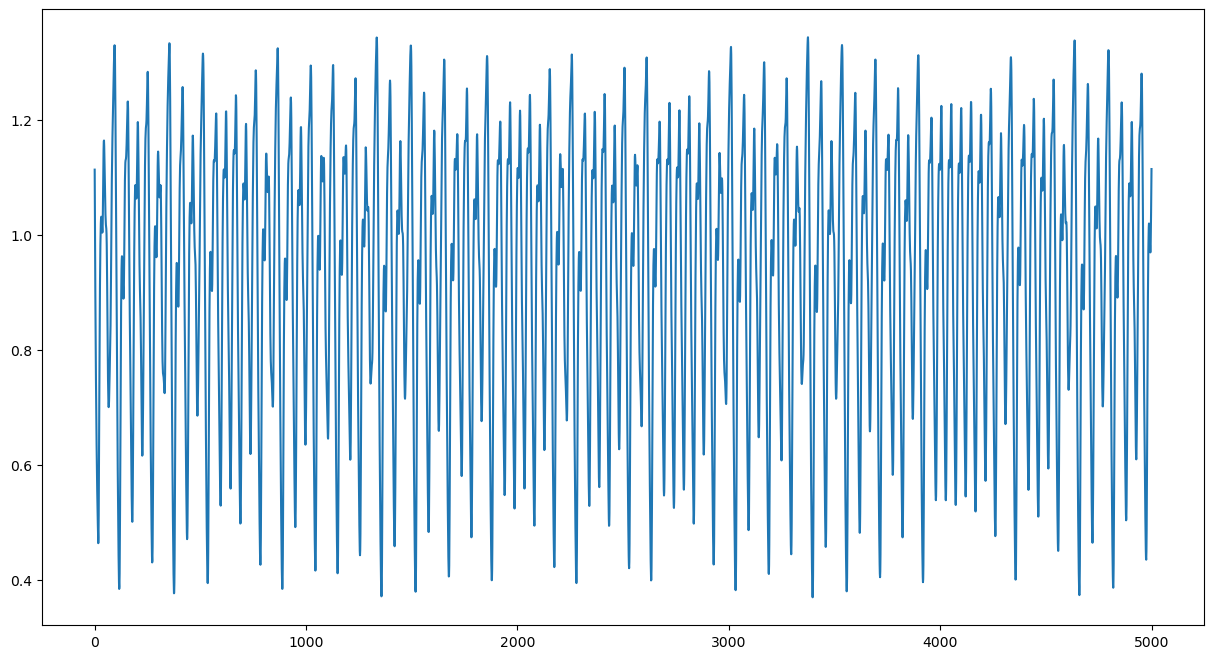

In [20]:
plt.figure(figsize=(15,8))
plt.plot(mgd)
plt.show()

### Laser Map

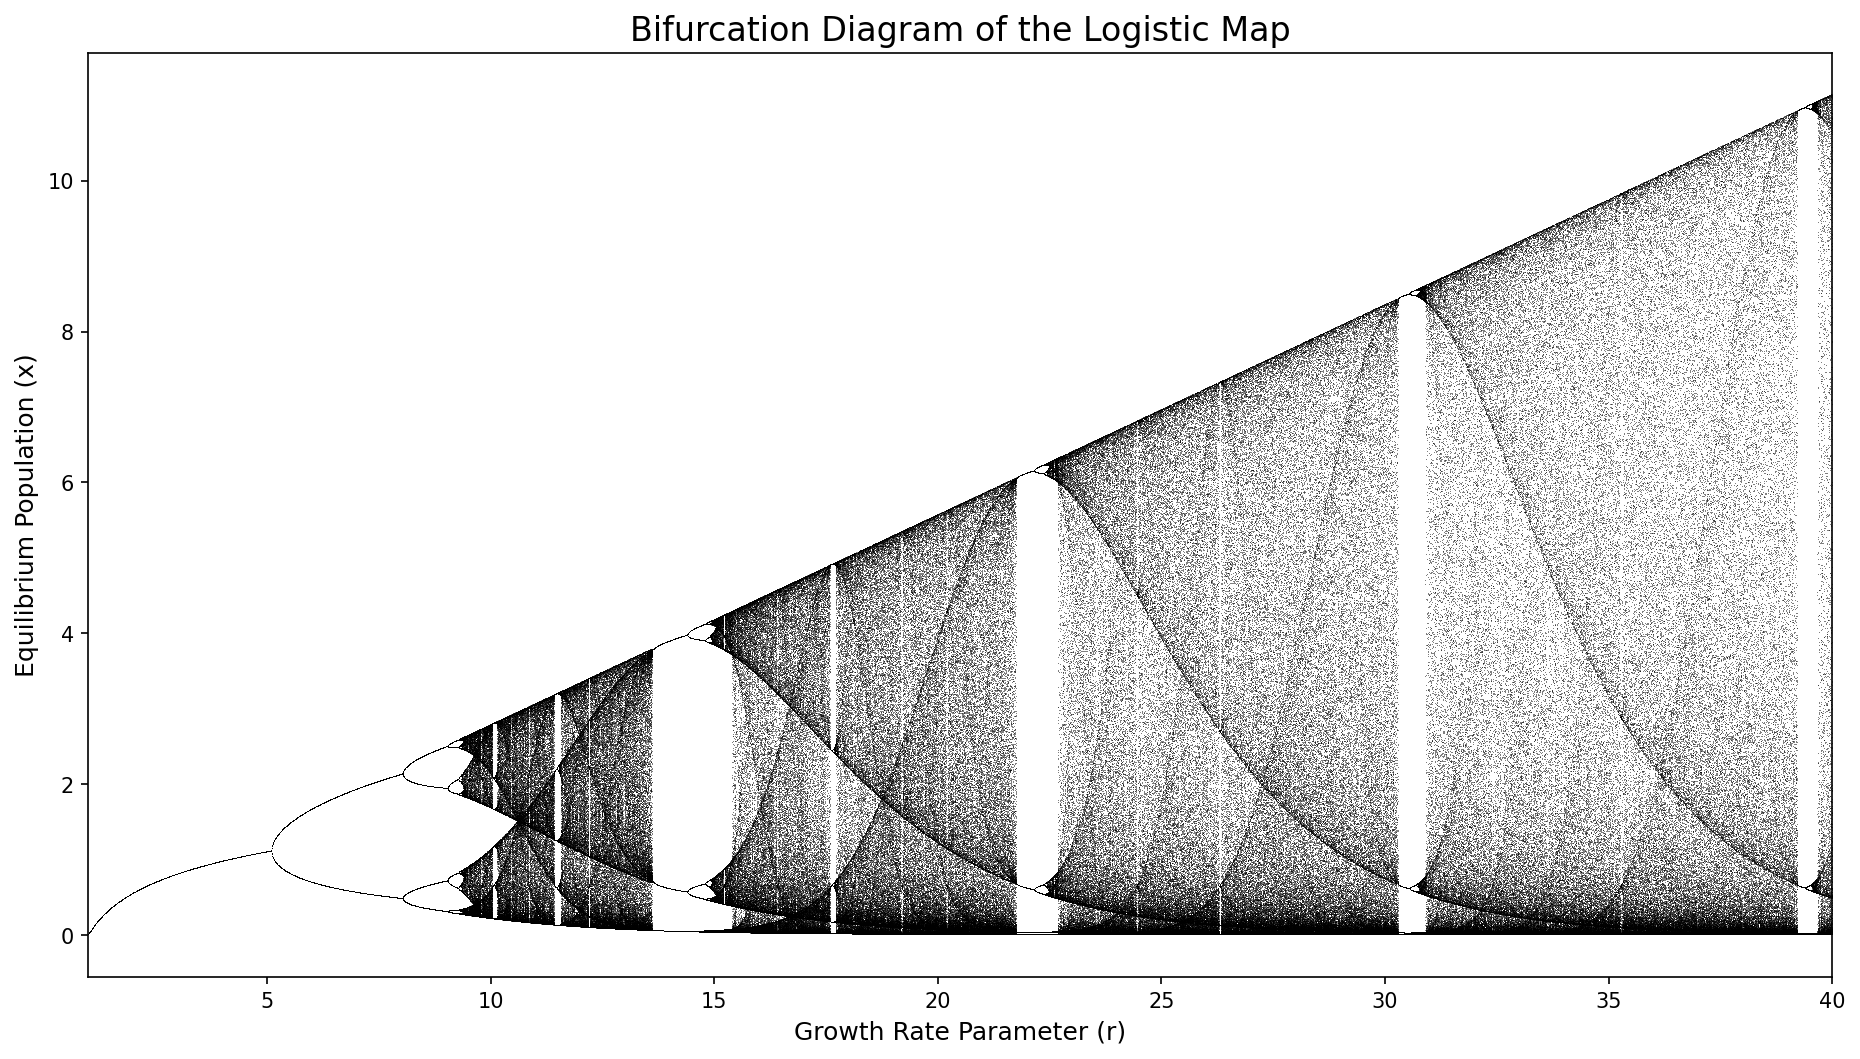

In [21]:
plot_bifur_laser(np.linspace(1, 40, 5000), x0=0.2)

### Lorenz63

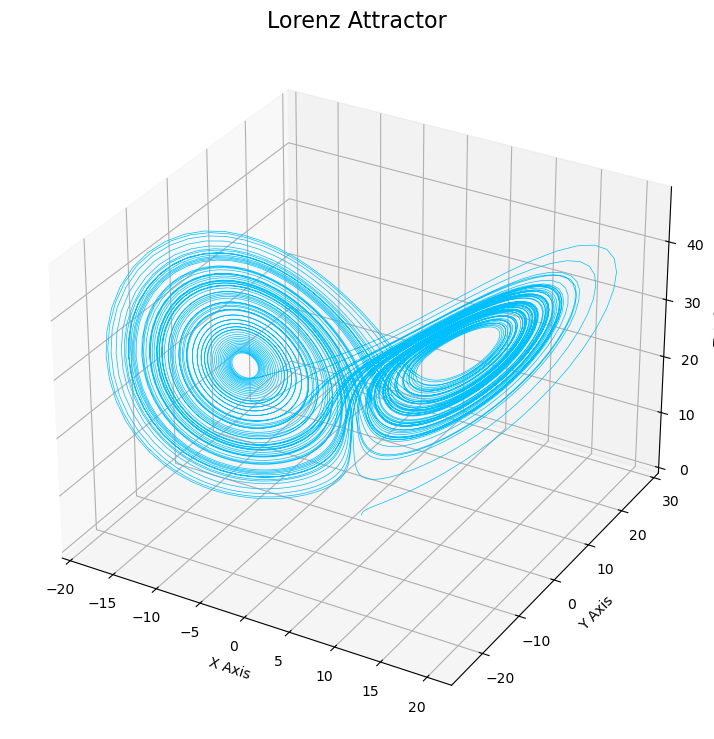

In [22]:
plot_lorenz_attractor(generate_lorenz())

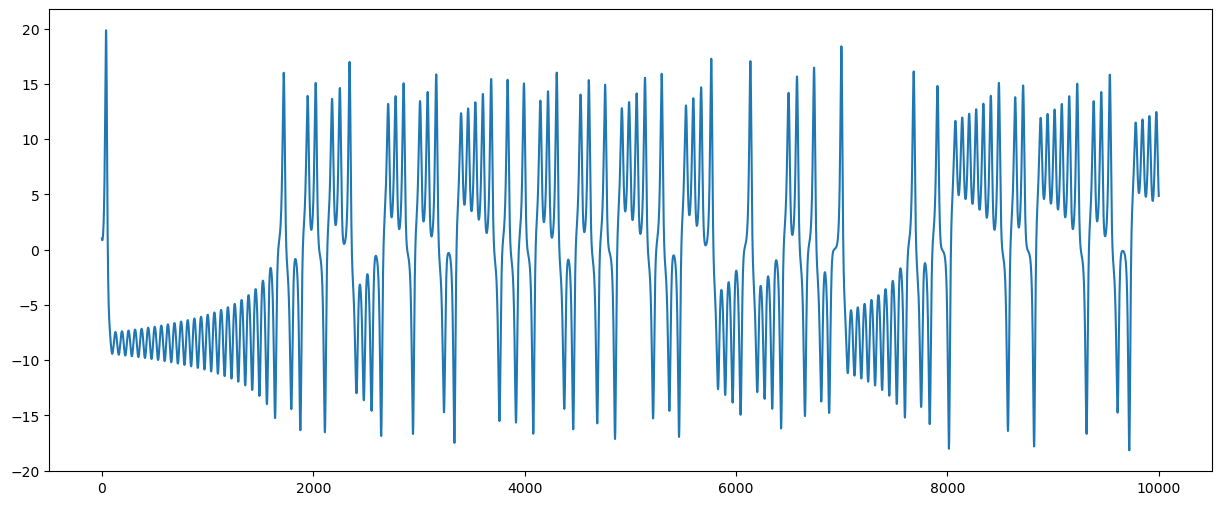

In [43]:
lorenz_x = generate_lorenz(dt=0.01, num_steps=10000)[:, 0]

plt.figure(figsize=(15,6))
plt.plot(lorenz_x)
# plt.plot(lor_y)
# plt.plot(lor_z)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


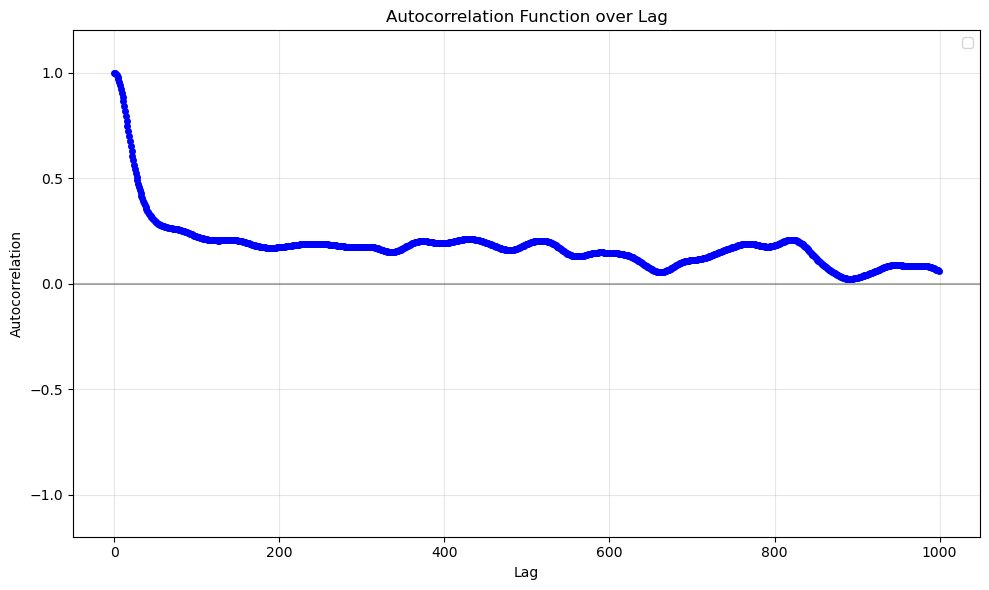

[1.0,
 0.9987903731228142,
 0.9950242497859592,
 0.9887519516388398,
 0.9800564190195805,
 0.9690508488188511,
 0.9558755497651128,
 0.9406941738644445,
 0.9236894962084824,
 0.9050589248142147,
 0.8850099253061267,
 0.8637555319961718,
 0.8415100931770472,
 0.8184853712207621,
 0.7948870839843284,
 0.7709119546856674,
 0.7467453040107418,
 0.7225591604150433,
 0.6985108902245458,
 0.6747423135997564,
 0.6513792593942334,
 0.6285315070426533,
 0.6062930469937116,
 0.5847426047651123,
 0.5639443599829355,
 0.5439488521989688,
 0.5247939940145576,
 0.5065061505751578,
 0.48910125132445664,
 0.472585904342869,
 0.4569584900311239,
 0.4422102312005246,
 0.4283261986111902,
 0.4152862995503541,
 0.4030661705515388,
 0.3916380021355917,
 0.38097130174327837,
 0.37103357128478637,
 0.3617909251045226,
 0.3532086363861588,
 0.3452515771742185,
 0.33788460135314186,
 0.33107287668519514,
 0.3247821741067611,
 0.31897907702364964,
 0.31363117715264777,
 0.3087072373197673,
 0.30417732327158825,


In [44]:
plot_acf(lorenz_x, 1000)

### PCA SUBSPACE TRACKING: Test cross recon loss; take a time series, split it into disjoint subsets, then carry out experiments
### measures system stability or uniformity

In [24]:
lgm_seg1, lgm_seg2 = lgm[:1500], lgm[1500:]

emb_dim, emb_del, pca_dim = 10, 1, 10
seg1_de, pca1 = delayPCA(lgm_seg1, emb_dim, emb_del, pca_dim)
seg2_de, pca2 = delayPCA(lgm_seg2, emb_dim, emb_del, pca_dim)

In [25]:
mse, _, x_hat = pca_cross_recon_loss(delay_embed(lgm_seg2, emb_dim, emb_del), pca2, pca2, pca_dim)
print(mse)

3.3546294932260827e-31


In [26]:
r_vals = np.linspace(3.0, 4.0, 100)
pca_cross_loss_lgm = []
pca_recon_loss_lgm = []

for r in r_vals: 
    data = logistic_map(r, 0.5, 1256)
    seg1, seg2 = data[:1000], data[1000:]
    seg1_emb, pca1 = delayPCA(seg1, emb_dim, emb_del, pca_dim)
    seg2_emb, pca2 = delayPCA(seg2, emb_dim, emb_del, pca_dim)

    mse_cross, _, _ = pca_cross_recon_loss(delay_embed(seg2, emb_dim, emb_del), pca2, pca1, pca_dim)
    mse_reg, _, _ = pca_recon_loss(delay_embed(seg2, emb_dim, emb_del), pca2, pca_dim)

    pca_cross_loss_lgm.append(mse_cross)
    pca_recon_loss_lgm.append(mse_reg)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:559: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74427/2207249370.py:211: RuntimeWarning: divide by zero encountered in divide
  r2 = 1.0 - per_feature/var_j
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74427/2207249370.py:211: RuntimeWarning: invalid value encountered in divide
  r2 = 1.0 - per_feature/var_j
/var/folders/k6/p59hn9vn3nl08dp9_ybv466c0000gn/T/ipykernel_74427/2207249370.py:184: RuntimeWarning: invalid value encountered in divide
  r2 = 1.0 - per_feature/var_j


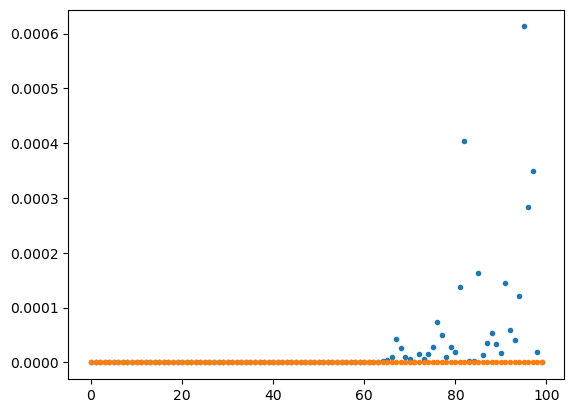

In [28]:
plt.plot(pca_cross_loss_lgm, '.')
plt.plot(pca_recon_loss_lgm, '.')
plt.show()